### Time series analysis on Energy Consumption Data
</br> 

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from matplotlib import pyplot
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
%matplotlib inline

In [2]:
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

### Reading the Data

In [3]:
df= pd.read_csv('/home/rohan/AML2/EKPC_hourly.csv')
#print the head
df.head()

,Datetime,EKPC_MW
0,2013-12-31 01:00:00,1861.0
1,2013-12-31 02:00:00,1835.0
2,2013-12-31 03:00:00,1841.0
3,2013-12-31 04:00:00,1872.0
4,2013-12-31 05:00:00,1934.0


#### Preprocessing

In [4]:
#Checking whether there is any null value or not
df.isnull().any()
#sort the data in ascending order of time
df=df.set_index('Datetime')
df = df.sort_index()
df.head()

Datetime    False
EKPC_MW     False
dtype: bool

,EKPC_MW
Datetime,
2013-06-01 01:00:00,1166.0
2013-06-01 02:00:00,1098.0
2013-06-01 03:00:00,1036.0
2013-06-01 04:00:00,1023.0
2013-06-01 05:00:00,949.0


In [5]:
data=np.array(df["EKPC_MW"]) #storing the energy consumption as an array named data

### Data Visualisation

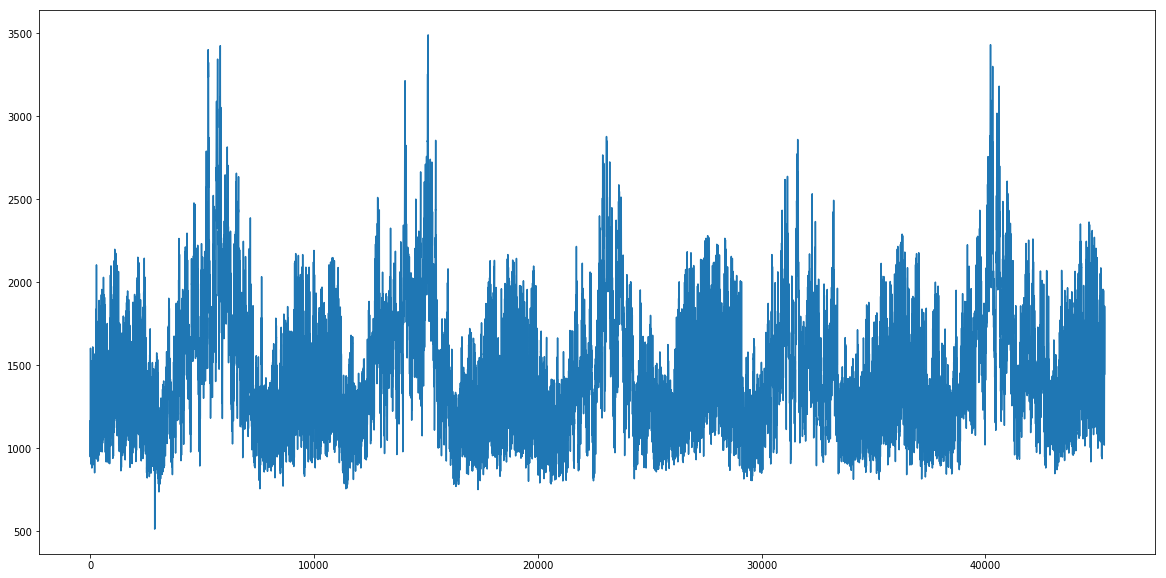

In [6]:
plt.plot(data)

### Train-Test Split

In [7]:
timeseries=list(df["EKPC_MW"]) # Energy consumption
#Train Data
train_series=timeseries[:36000]
#Test Data
test_series=timeseries[36000:]

In [8]:
#length of the whole,train & test series
len(timeseries)
len(train_series)
len(test_series)

45334

36000

9334

### Test for Stationarity : Augmented Dickey Fuler Test

In [9]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

In [10]:
def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)


#### Checking stationarity for the whole time-series data

In [11]:
sTest = StationarityTests()
ADF_Stationarity_Test(sTest,timeseries, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.160116e+01
P-Value                 2.646802e-21
# Lags Used             5.600000e+01
# Observations Used     4.527700e+04
Critical Value (1%)    -3.430494e+00
Critical Value (5%)    -2.861604e+00
Critical Value (10%)   -2.566804e+00
dtype: float64
Is the time series stationary? True


From the Augmented Dickey Fuler test We find that our timeseries data is stationary.

#### Checking stationarity for the train series

In [12]:
sTest = StationarityTests()
ADF_Stationarity_Test(sTest,train_series, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.073615e+01
P-Value                 2.895578e-19
# Lags Used             5.300000e+01
# Observations Used     3.594600e+04
Critical Value (1%)    -3.430532e+00
Critical Value (5%)    -2.861620e+00
Critical Value (10%)   -2.566813e+00
dtype: float64
Is the time series stationary? True


Checking stationarity for train series separately we again find that the train series data is stationary.

### ACF-PACF Plot
</br> To decide the parameters of an ARIMA model we need to check the ACF and PACF plot.

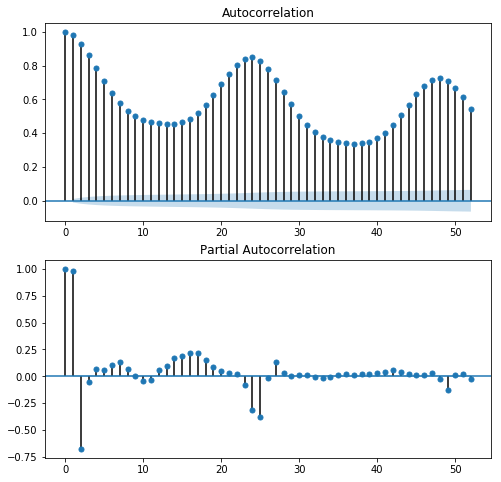

In [13]:
import statsmodels.api as sm
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_series, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_series, lags=52, ax=ax2)

### Fitting Arima Model

In [14]:
#We chose our parameters 
#It took 10 mins even with a 16 gb ram system
start=time.time()
model = ARIMA(train_series, order=(24,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
end=time.time()
print(end-start)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                36000
Model:                    ARMA(24, 2)   Log Likelihood             -186854.970
Method:                       css-mle   S.D. of innovations             43.436
Date:                Fri, 10 May 2019   AIC                         373765.941
Time:                        17:38:40   BIC                         374003.697
Sample:                             0   HQIC                        373841.571
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1449.3078     22.652     63.980      0.000    1404.910    1493.706
ar.L1.y        2.0361      0.010    208.131      0.000       2.017       2.055
ar.L2.y       -1.6478      0.020    -82.464      0.0

### Prediction on test data

In [15]:
forecast = model_fit.predict(start = 36000, end= 45333, dynamic= True)

### Visualizing the test data and forecast

ARIMA RMS is : 391.97133684621963


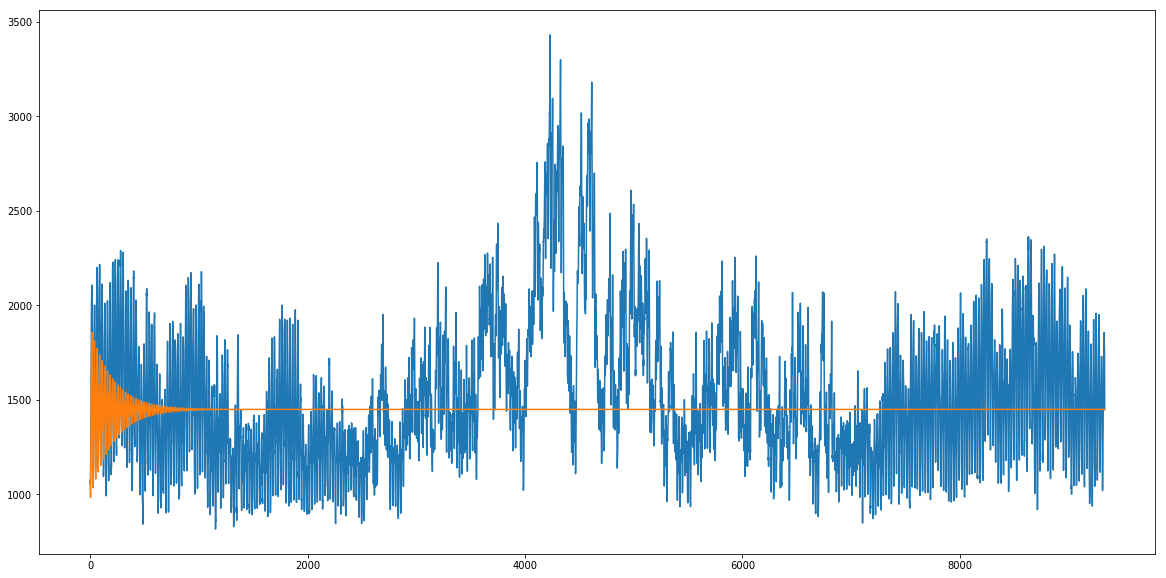

In [21]:
forecast = model_fit.predict(start = 36000, end= 45333, dynamic= True)
forecast = pd.DataFrame(forecast,columns=['Prediction'])

rms=np.sqrt(np.mean(np.power((np.array(test_series)-np.array(forecast['Prediction'])),2)))
print("ARIMA RMS is : " + str(rms))
#plt.plot(train_series)
plt.plot(test_series)
plt.plot(forecast['Prediction'])

**Comment:** Arima model fitted very Badly.There are various seasonal factors(hourly,daily,weekly,monthly) which may be present in the data. We haven't taken into consideration those seasonal factors.
<br>ARIMA model can not work properly when various type of seasonal factors present in the data.

In [23]:
#Optional code
# test_dataframe=pd.DataFrame(list(zip(test_series,forecast)),
#              columns=['test_series','forecast'])

# test_dataframe[['test_series', 'forecast']].plot(figsize=(12, 8))

### Code for Auto-arima model
</br> It gives us flexibility to choose the range of the order of the AR,MA 
</br> To run it we need high computation power as the data is very large and it tries all possible combination of the three parameters in the given range,
but we will not get any satisfactory result due to the presence of various seasonal factors.

In [24]:
# from pyramid.arima import auto_arima

# #data = df.sort_index(ascending=True, axis=0)

# train = data[:36000]
# # valid = data[36000:]

# # training = train['Close']
# # validation = valid['Close']

# model = auto_arima(train_series, start_p=1, start_q=1,max_p=3, max_q=3, m=7,start_P=0, seasonal=True,d=0, D=1, trace=True,error_action='ignore',suppress_warnings=True)
# model.fit(train_series)

# forecast = model.predict(n_periods=390)
# forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

# rms=np.sqrt(np.mean(np.power((np.array(test_series)-np.array(forecast['Prediction'])),2)))
# print("ARIMA RMS is : " + str(rms))
# print("R-squared score is : " + str(r2_score(np.array(test_series),np.array(forecast['Prediction']))))
# #plot ARIMA
# plt.plot(train_series)
# plt.plot(test_series)
# plt.plot(forecast['Prediction'])

### Code for SARIMA model
</br> (Seasonal Arima)
</br> It also requires very high computation power 

In [25]:
# my_order = (2, 0, 1)
# my_seasonal_order = (2, 0, 1, 24)  #hourly data
# # define model
# model = sm.tsa.statespace.SARIMAX(train_series, order=my_order, seasonal_order=my_seasonal_order)
# model_fit = model.fit()

In [26]:
# start=time.time()
# my_order = (2, 0, 1)
# my_seasonal_order = (2, 0, 1, 24)
# # define model
# model = sm.tsa.statespace.SARIMAX(train_series, order=my_order, seasonal_order=my_seasonal_order)
# model_fit = model.fit()
# print(model_fit.summary())
# end=time.time()
# print(end-start)

### Time series analysis on Daily Energy Consumption
</br> Now we convert our hourly data to daily data and see how arima model works on daily energy consumption data

In [27]:
df.head()
df.shape

,EKPC_MW
Datetime,
2013-06-01 01:00:00,1166.0
2013-06-01 02:00:00,1098.0
2013-06-01 03:00:00,1036.0
2013-06-01 04:00:00,1023.0
2013-06-01 05:00:00,949.0


(45334, 1)

In [28]:
df.index = pd.to_datetime(df.index)
df.shape

(45334, 1)

In [29]:
daily=df.resample('D').sum() #take sum of all the hourly values in a particular date 
print("The daily energy consumption data:")
daily.head()
daily.shape

The daily energy consumption data:


,EKPC_MW
Datetime,
2013-06-01,30445.0
2013-06-02,29403.0
2013-06-03,29710.0
2013-06-04,29478.0
2013-06-05,30962.0


(1890, 1)

### Visualisation of Daily Energy consumption data

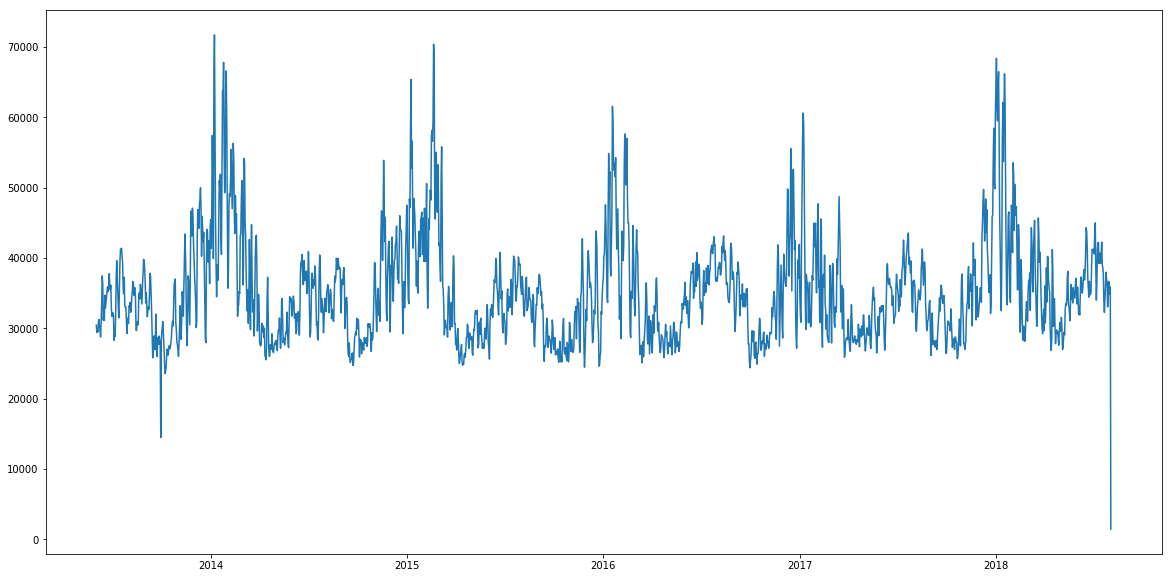

In [30]:
plt.plot(daily['EKPC_MW'])

### Train-Test split

In [31]:
dailyseries=list(daily["EKPC_MW"])
train_daily=dailyseries[:1500]
test_daily=dailyseries[1500:]
#print(series)

### Checking for stationarity

In [32]:
sTest = StationarityTests()
ADF_Stationarity_Test(sTest,dailyseries, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -4.534034
P-Value                    0.000171
# Lags Used               15.000000
# Observations Used     1874.000000
Critical Value (1%)       -3.433844
Critical Value (5%)       -2.863084
Critical Value (10%)      -2.567592
dtype: float64
Is the time series stationary? True


### ACF-PACF Plot
</br> To decide the parameters of an ARIMA model we need to check the ACF and PACF plot.

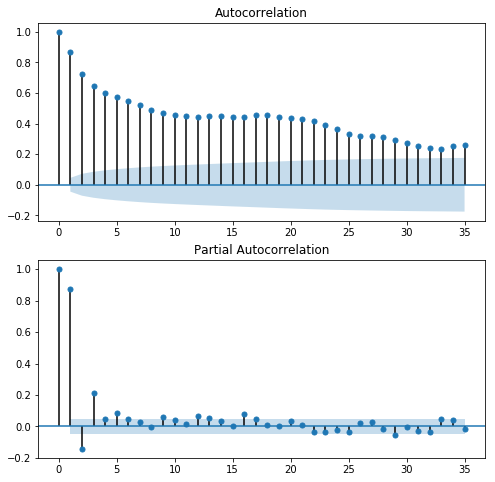

In [33]:
import statsmodels.api as sm
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dailyseries, lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dailyseries, lags=35, ax=ax2)

### Fitting ARIMA model

In [34]:
start=time.time()
model = ARIMA(train_daily, order=(2,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
end=time.time()
print(end-start)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1500
Model:                     ARMA(2, 1)   Log Likelihood              -14313.080
Method:                       css-mle   S.D. of innovations           3369.621
Date:                Fri, 10 May 2019   AIC                          28636.160
Time:                        18:03:10   BIC                          28662.726
Sample:                             0   HQIC                         28646.057
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.478e+04    635.589     54.722      0.000    3.35e+04     3.6e+04
ar.L1.y        0.4865      0.062      7.903      0.000       0.366       0.607
ar.L2.y        0.2905      0.057      5.058      0.0

### Prediction on test data

In [ ]:
forecast = model_fit.predict(start = 1500, end= 1890, dynamic= True)  

###  Visualizing the test data and forecast

ARIMA RMS is : 7830.918467774458


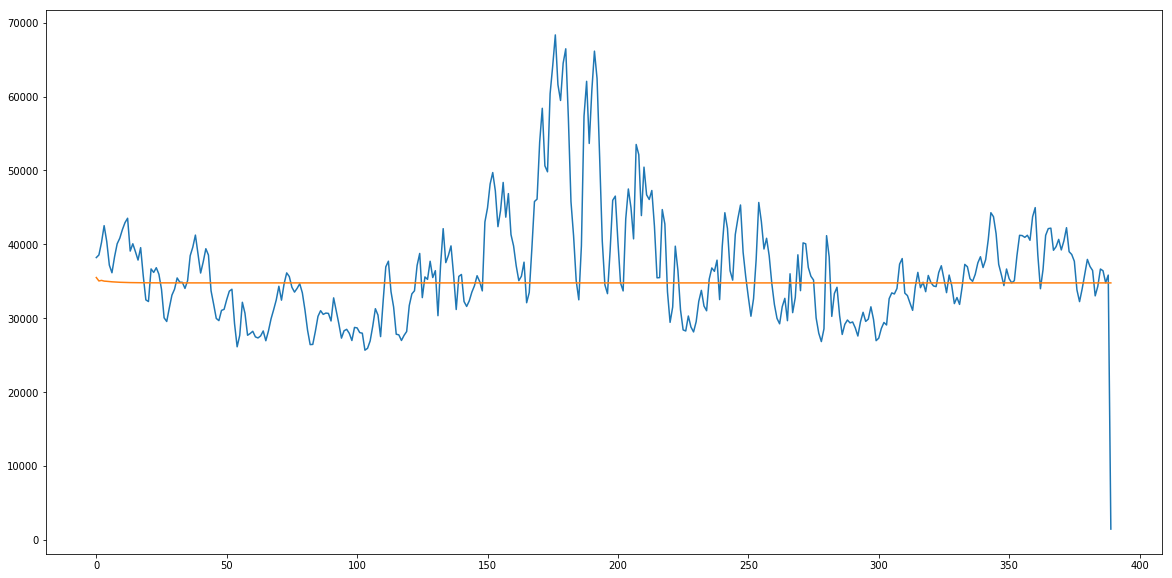

In [36]:
forecast = model_fit.predict(start = 1500, end= 1889, dynamic= True)
forecast = pd.DataFrame(forecast,columns=['Prediction'])

rms=np.sqrt(np.mean(np.power((np.array(test_daily)-np.array(forecast['Prediction'])),2)))
print("ARIMA RMS is : " + str(rms))
#plt.plot(train_series)
plt.plot(test_daily)
plt.plot(forecast['Prediction'])

**Comment:** Again Arima model fitted very Badly.We still have other seasonal factors present in the data.
So ARIMA model can not work properly when various type of seasonal factors present in the data.

In [37]:
#OPtional Code
# test_dataframe=pd.DataFrame(list(zip(test_daily,forecast)),
#               columns=['test_daily','forecast'])

# test_dataframe[['test_daily', 'forecast']].plot(figsize=(12, 8))

## Fbprophet
</br> Prophet is an open source library published by Facebook that is based ondecomposable (trend+seasonality+holidays) models.  It provides us with the ability to make time series predictions with good accuracy using simpleintuitive parameters and has support for including impact of customseasonality and holidays.

#### Fitting Fbprophet Model
</br> We saw ARIMA fitted very badly due to presence of various seasonal factors, we now use fbprophet model as it has the capability the capture all type of seasonal variations present in the time series data.

In [39]:
import fbprophet

In [40]:
df2=df
df2.reset_index(inplace=True)
df2=df2.rename(columns={'Datetime':'ds','EKPC_MW': 'y'})

In [41]:
df2_train=df2[:36000]
df2_test=df2[36000:]
df2_train.head()
df2_test.head()

,ds,y
0,2013-06-01 01:00:00,1166.0
1,2013-06-01 02:00:00,1098.0
2,2013-06-01 03:00:00,1036.0
3,2013-06-01 04:00:00,1023.0
4,2013-06-01 05:00:00,949.0


,ds,y
36000,2017-07-10 03:00:00,1071.0
36001,2017-07-10 04:00:00,1053.0
36002,2017-07-10 05:00:00,1066.0
36003,2017-07-10 06:00:00,1068.0
36004,2017-07-10 07:00:00,1183.0


In [42]:
prophet=fbprophet.Prophet()
prophet.fit(df2_train)

/home/rohan/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


In [43]:
#fb_forecast=prophet.make_future_dataframe(periods=9334,freq='H')
fb_forecast=prophet.predict(df2_test.reset_index())

In [44]:
fb_forecast.shape

(9334, 22)

### Visualizing the train and forecast on test data

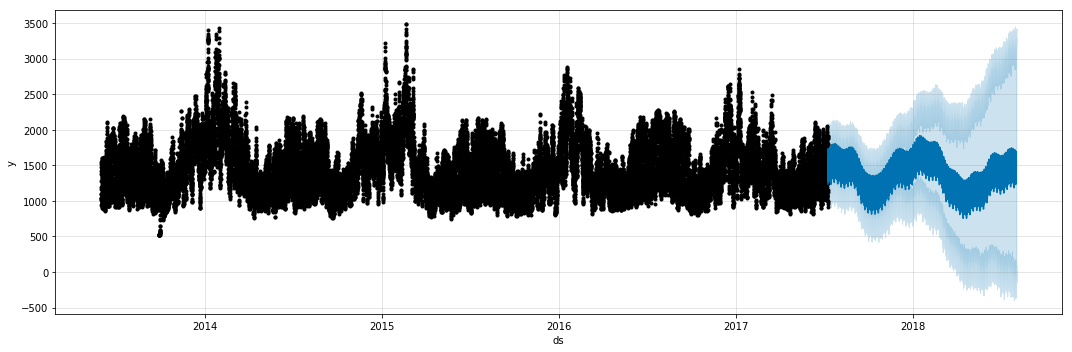

In [47]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
#ax.scatter(df2_test.index, df2_test['y'], color='r')
fig = prophet.plot(fb_forecast, ax=ax)

### Seasonal Variatons
</br> Plotted for test data

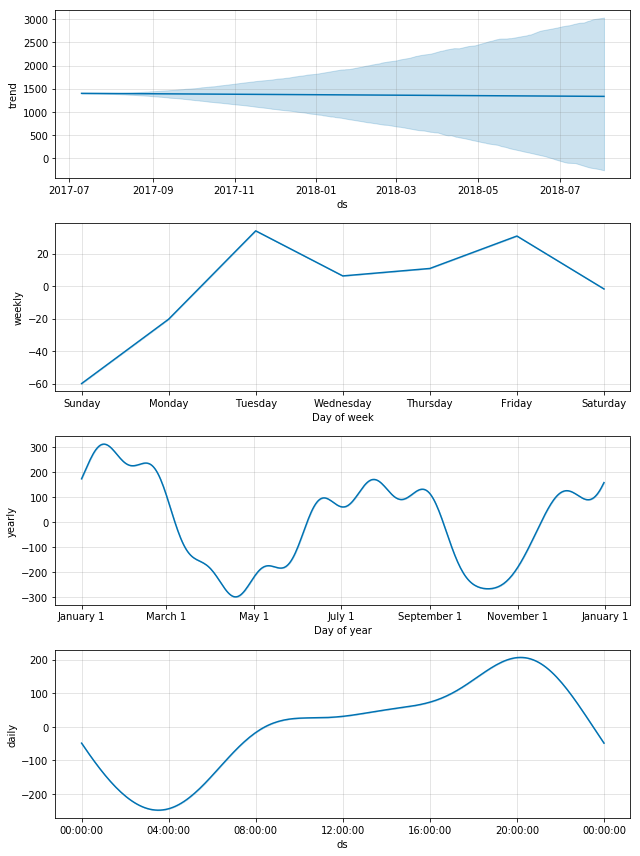

In [48]:
fig = prophet.plot_components(fb_forecast)

In [49]:
df2_test.index

RangeIndex(start=36000, stop=45334, step=1)

In [50]:
fb_forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-10 03:00:00,1399.461365,894.862770,1571.730941,1399.461365,1399.461365,-160.159225,-160.159225,-160.159225,-242.785607,...,-9.867851,-9.867851,-9.867851,92.494233,92.494233,92.494233,0.0,0.0,0.0,1239.302141
1,2017-07-10 04:00:00,1399.454358,900.632925,1582.986808,1399.454358,1399.454358,-157.422397,-157.422397,-157.422397,-243.823892,...,-6.401403,-6.401403,-6.401403,92.802899,92.802899,92.802899,0.0,0.0,0.0,1242.031961
2,2017-07-10 05:00:00,1399.447350,946.884208,1628.254040,1399.447350,1399.447350,-117.973095,-117.973095,-117.973095,-208.103443,...,-2.982142,-2.982142,-2.982142,93.112490,93.112490,93.112490,0.0,0.0,0.0,1281.474255


### Visualization of the test data and forecast on test data

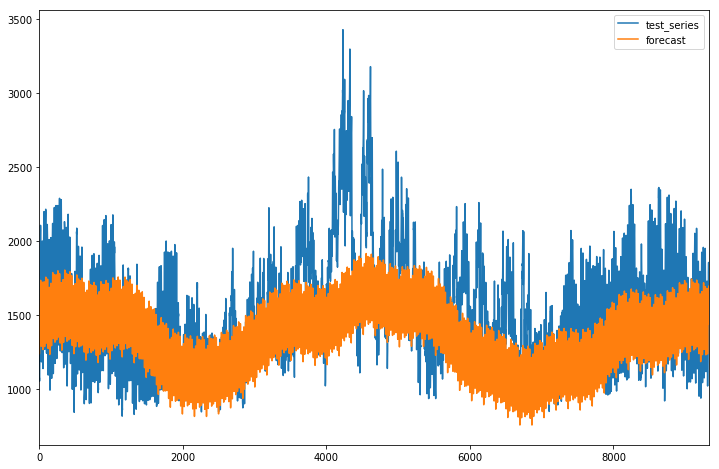

In [51]:
test_dataframe=pd.DataFrame(list(zip(df2_test['y'],fb_forecast['yhat'])),
              columns=['test_series','forecast'])

test_dataframe[['test_series', 'forecast']].plot(figsize=(12, 8))

**Comment**: Fbprophet worked much better than ARIMA model. It has captured the variations to some extent. Though it has worked better than the ARIMA model, we still haven't got the satisfactory result. So we need to try some other model which can work better than this. 
</br> We have implemented LSTM model and obtained extremely well result.